In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
from math import sin, cos, sqrt, atan2, radians
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import seaborn as sns

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model.logistic import LogisticRegression
from sklearn.linear_model.logistic import LogisticRegressionCV
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import recall_score as recall
from sklearn.metrics import precision_score as precision
from sklearn.metrics import f1_score as f1
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV

import scipy

In [3]:
pd.options.display.max_columns = 100
df = pd.read_csv('RawDataWithRpi.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1112 entries, 0 to 1111
Columns: 106 entries, team1_id to game_id
dtypes: float64(56), int64(38), object(12)
memory usage: 921.0+ KB


## Data Preprocess 数据预处理

### Delete useless variables 删除无用变量

In [5]:
g = df.columns.to_series().groupby(df.dtypes).groups
dic = {k.name: v for k, v in g.items()}
cat = list(dic['object'])
# keep 'game_id'
cat.remove('game_id')

In [6]:
df.drop(columns=cat,inplace=True)

In [7]:
delete = ['team1_id', 'team1_score', 'team2_id', 'team2_score','num_ot','strongseed','weakseed','season']
df.drop(columns = delete, inplace=True)

In [8]:
df.head()

,team1_seed,team2_seed,host_lat,host_long,team1_lat,team1_long,team2_lat,team2_long,team1_pt_school_ncaa,team1_pt_overall_ncaa,team1_pt_school_s16,team1_pt_overall_s16,team1_pt_school_ff,team1_pt_overall_ff,team1_pt_career_school_wins,team1_pt_career_school_losses,team1_pt_career_overall_wins,team1_pt_career_overall_losses,team1_pt_team_season_wins,team1_pt_team_season_losses,team1_pt_coach_season_wins,team1_pt_coach_season_losses,team2_pt_school_ncaa,team2_pt_overall_ncaa,team2_pt_school_s16,team2_pt_overall_s16,team2_pt_school_ff,team2_pt_overall_ff,team2_pt_career_school_wins,team2_pt_career_school_losses,team2_pt_career_overall_wins,team2_pt_career_overall_losses,team2_pt_team_season_wins,team2_pt_team_season_losses,team2_pt_coach_season_wins,team2_pt_coach_season_losses,team1_ap_final,team1_ap_preseason,team1_coaches_before_final,team1_coaches_preseason,team2_ap_final,team2_ap_preseason,team2_coaches_before_final,team2_coaches_preseason,team1_fg2pct,team1_fg3pct,team1_ftpct,team1_blockpct,team1_oppfg2pct,team1_oppfg3pct,team1_oppftpct,team1_oppblockpct,team1_f3grate,team1_oppf3grate,team1_arate,team1_opparate,team1_stlrate,team1_oppstlrate,team2_fg2pct,team2_fg3pct,team2_ftpct,team2_blockpct,team2_oppfg2pct,team2_oppfg3pct,team2_oppftpct,team2_oppblockpct,team2_f3grate,team2_oppf3grate,team2_arate,team2_opparate,team2_stlrate,team2_oppstlrate,team1_tempo,team1_adjtempo,team1_oe,team1_adjoe,team1_de,team1_adjde,team2_tempo,team2_adjtempo,team2_oe,team2_adjoe,team2_de,team2_adjde,team1_rpi,team2_rpi,game_id
0,16,16,39.7594,-84.1917,42.718586,-73.751530,31.877216,-91.142854,0,0,0,0,0,0,16,18,16,18,16,18,16,18,6,6,0,0,0,0,317,210,317,210,20,9,20,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.6127,34.6260,74.4032,11.3308,42.6616,33.6399,69.6471,10.5144,35.3229,36.6570,54.5135,57.8947,0.0778,0.1020,48.9138,37.5556,64.2105,9.4340,47.6981,34.1071,70.6505,6.4471,23.9744,29.7082,54.3253,56.8651,0.1080,0.1049,68.8425,67.7359,98.6930,98.6102,96.3688,99.6885,76.0664,73.8504,103.4213,99.8665,99.6370,106.4500,0.474,0.502,2002-1373-1108
1,2,15,35.6017,-77.3725,33.214400,-87.545766,26.372536,-80.102293,0,2,0,0,0,0,81,49,149,73,26,7,26,7,0,0,0,0,0,0,28,63,28,63,19,11,19,11,8.0,24.0,8.0,NaN,NaN,NaN,NaN,NaN,50.6579,30.8677,73.5782,8.0468,45.2085,31.7841,68.2422,7.1637,33.9450,32.7925,50.5495,46.9880,0.1053,0.0881,45.0355,33.9114,66.7785,8.1871,48.5380,34.3925,68.8172,9.9291,26.9051,30.8891,56.5968,56.3399,0.1282,0.1076,69.8636,69.9001,108.4361,111.4954,95.2313,93.8770,71.2357,71.2446,100.2897,96.8669,98.4183,99.9263,0.630,0.524,2002-1104-1194
2,3,14,35.1107,-106.6100,32.232071,-110.950769,34.415462,-119.848071,17,22,8,10,4,5,467,144,656,239,22,9,22,9,0,0,0,0,0,0,62,52,62,52,20,10,20,10,7.0,NaN,8.0,NaN,NaN,NaN,NaN,NaN,50.0000,37.6093,73.0769,7.2512,47.8576,34.7826,70.1258,8.4934,33.6275,31.9731,56.4706,54.8255,0.0835,0.0839,47.0414,40.8247,75.8117,8.7185,43.1723,32.0968,69.3679,6.7061,32.3549,39.4402,65.7778,58.5246,0.0868,0.0778,74.1462,72.8207,111.0077,117.3877,104.0411,96.9262,63.2345,64.7948,105.2163,105.4534,96.0965,97.6704,0.634,0.542,2002-1112-1364
3,1,16,35.6017,-77.3725,36.001590,-78.942260,34.938510,-81.028663,17,17,12,12,9,9,562,167,635,226,29,3,29,3,3,3,0,0,0,0,79,41,79,41,19,11,19,11,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,57.4329,36.2651,68.9845,7.2251,46.2916,30.2703,68.8693,7.4692,37.5736,26.1916,57.1821,49.5516,0.1297,0.0919,47.6420,30.5603,65.5914,11.6301,45.6625,30.4104,68.8372,9.8171,36.1794,33.8170,49.0370,51.8692,0.1108,0.0987,77.0734,75.1685,116.3726,118.5999,90.2544,87.7504,68.2128,67.4639,100.2384,95.3632,94.6587,99.9754,0.655,0.474,2002-1181-1457
4,5,12,38.5556,-121.4689,39.166383,-86.526904,40.762484,-111.846044,1,1,0,0,0,0,41,24,41,24,20,11,20,11,8,9,4,4,1,1,283,81,382,133,21,8,21,8,NaN,22.0,NaN,NaN,NaN,NaN,NaN,NaN,48.3696,40.0000,69.4561,12.5086,42.8866,35.5839,66.4013,10.0155,33.0213,27.3590,58.4949,48.2295,0.1045,0.1075,50.3060,40.4719,67.9443,7.3961,49.1388,31.8302,70.6406,7.3439,40.2778,27.6393,63.7224,51.5702,0.0922,0.0927,65.

### Missing Values 缺失值
#### check missing values

In [9]:
for i in df.columns:
    if any(df[i].isnull()) == True:
        ratio = np.sum(df[i].isnull())/len(df)*100
        print(i,'has missing values in %f percent' % ratio)

team1_ap_final has missing values in 31.744604 percent
team1_ap_preseason has missing values in 41.456835 percent
team1_coaches_before_final has missing values in 31.294964 percent
team1_coaches_preseason has missing values in 44.874101 percent
team2_ap_final has missing values in 63.758993 percent
team2_ap_preseason has missing values in 69.244604 percent
team2_coaches_before_final has missing values in 65.557554 percent
team2_coaches_preseason has missing values in 70.863309 percent


#### These variable only record top25 teams, so a lot of teams have missing value. I use a number larger than 25 (32) to fill.  这些数据确实是因为官网只记录前25， 所以我用一个比25大写的数字（32）去补充缺失值

In [10]:
df.fillna(32,inplace=True)

### Outliers 异常值检查
#### check outliers 

In [11]:
g = df.columns.to_series().groupby(df.dtypes).groups
dic = {k.name: v for k, v in g.items()}
cols = list(dic['float64']) 

In [12]:
# only check variables about team statistics in game
# 只检查球队的比赛数据统计
cols = cols[14:-2]
len(cols)

40

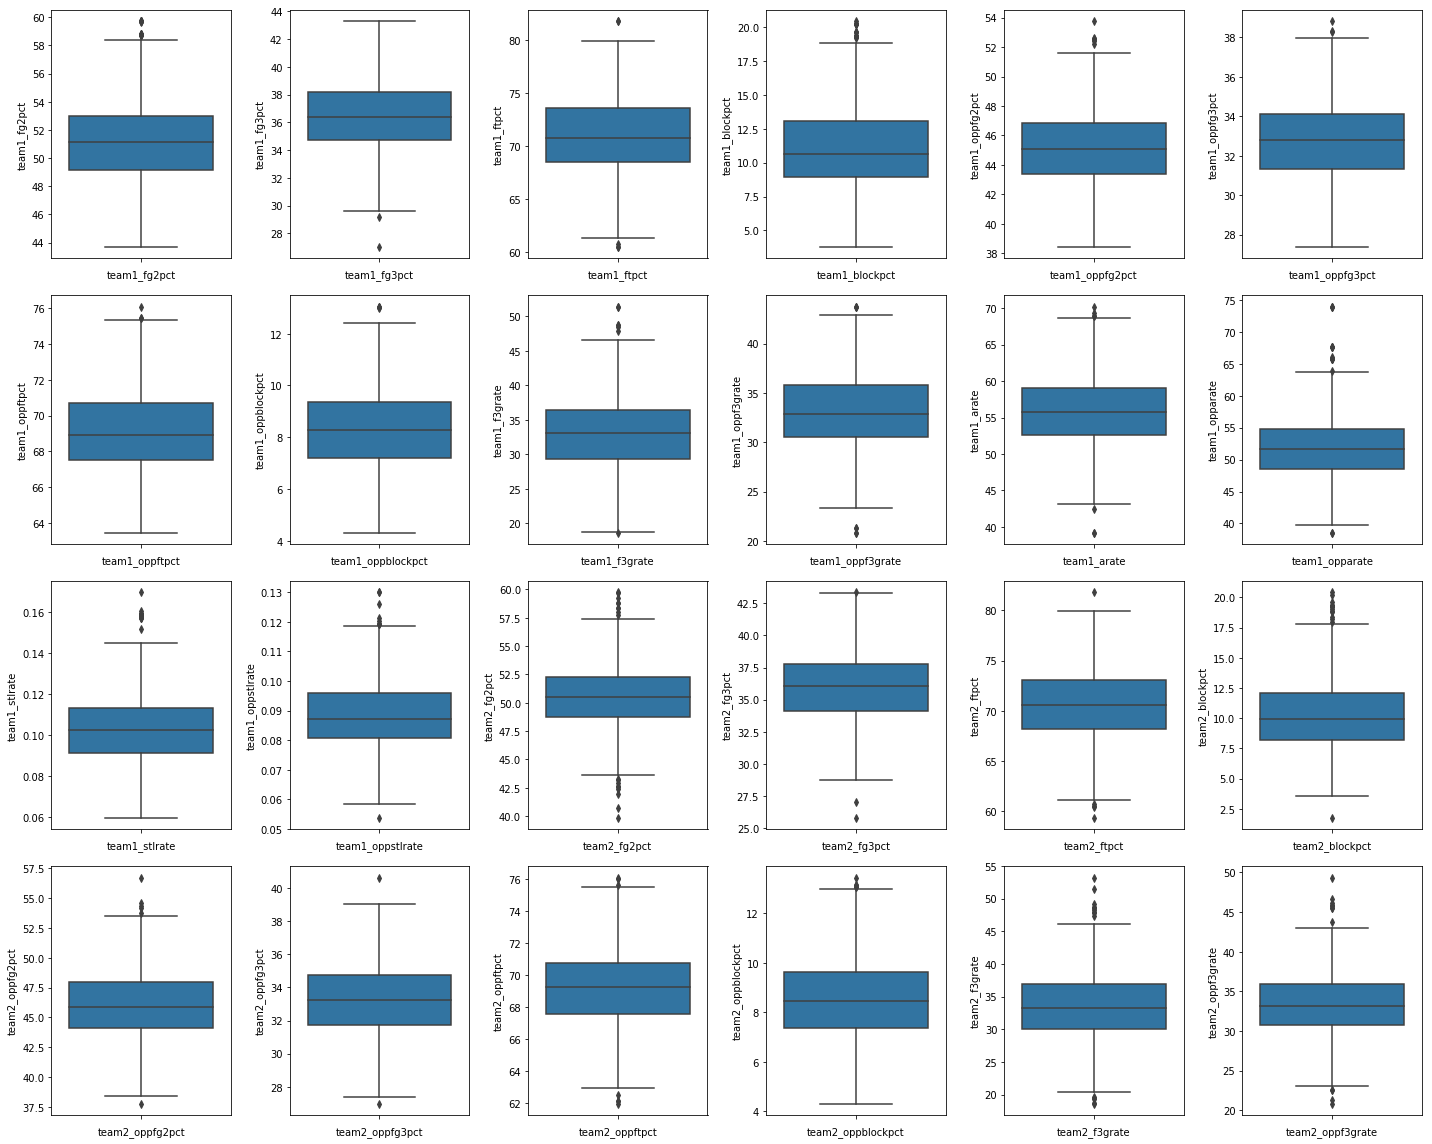

In [13]:
fig, axes = plt.subplots(ncols=6, nrows=4,figsize=(20,16))
for i, ax in zip(cols, axes.flatten()):
    sns.boxplot(df[i], ax=ax,orient='v')
    ax.set(xlabel=i)
fig.tight_layout()
plt.show()

#### Seems there is no obvious outilers  初步看来没有明显异常值

##  Calsulate distance from host Shuffle team1 and team2 for prediction 计算距离比赛场地的距离并打乱队伍的顺序方便预测

In [14]:
def distance(lat1, lon1, lat2, lon2):

    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    
    return distance

In [15]:
df['team1_distance'] = df.apply(lambda row: distance(row['host_lat'], row['host_long'], row['team1_lat'], row['team1_long']), axis=1)
df['team2_distance'] = df.apply(lambda row: distance(row['host_lat'], row['host_long'], row['team2_lat'], row['team2_long']), axis=1)
df.drop(columns = ['host_lat','host_long','team1_lat','team2_lat','team1_long','team2_long'],inplace=True)

In [16]:
def shuffle(df):
    g = df.sample(frac=1).reset_index(drop=True)
    df1,df2 = g.iloc[:int(len(g)/2),:], g.iloc[int(len(g)/2):,:]   
    assert df1.shape[0] + df2.shape[0] == df.shape[0] ## have 1/2 number of rows of original df 
    # exchange team1 and team2 so that team1 is not always the winner
    a = [i for i in df.columns.values if 'team1' in i]
    b = [i for i in df.columns.values if 'team2' in i]
    values1,values2 = df1[a].values, df1[b].values
    df1[a], df1[b] = values2,values1
    # 1: team1 loses 0： team1 wins
    df1['label'], df2['label'] = np.ones(556),np.zeros(556)
    result = pd.concat([df1,df2])
    assert np.any(result['game_id'] == g['game_id'])
    return result.sort_values(by='game_id')

In [17]:
def rocCurve(prob):
    preds = prob[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [18]:
shuffled = shuffle(df)

In [19]:
def splitData(df):
    label = df['label'].values
    a = len(df[df['game_id'].str.contains('2017|2018')])
    g = df.drop(columns=['label','game_id'])
    return g[:-a],g[-a:],label[:-a],label[-a:]

In [20]:
log_clf = LogisticRegression()

In [21]:
def evaluate(model, X_train, X_test, y_train, y_test): 
    global prob_1,prob_2
    model.fit(X_train, y_train)
    prob_1 = model.predict_proba(X_train)
    predict_1 = model.predict(X_train)
    prob_2 = model.predict_proba(X_test)
    predict_2 = model.predict(X_test)

    print('Train Resutl:\nLogLoss: %f \nAccuracy: %f\nrecall: %f\nprecision: %f\nf1:%f' % \
          (log_loss(y_train,prob_1),acc(y_train, predict_1),recall(y_train, predict_1),precision(y_train, predict_1),\
          f1(y_train, predict_1)))
    print('\nTest Result:\nLogLoss: %f \nAccuracy: %f\nrecall: %f\nprecision: %f\nf1:%f' % \
          (log_loss(y_test,prob_2),acc(y_test, predict_2),recall(y_test, predict_2),precision(y_test, predict_2),\
          f1(y_test, predict_2))) 

In [22]:
X_train, X_test, y_train, y_test = splitData(shuffled)
evaluate(log_clf,X_train, X_test, y_train, y_test )

Train Resutl:
LogLoss: 0.469674 
Accuracy: 0.773006
recall: 0.775967
precision: 0.772819
f1:0.774390

Test Result:
LogLoss: 0.531532 
Accuracy: 0.723881
recall: 0.661538
precision: 0.741379
f1:0.699187


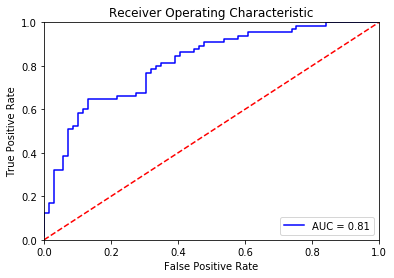

In [23]:
rocCurve(prob_2)

## Feature Engineering 特征工程

### Calculate  distance,seed difference, exp, log5
#### exp: the probability of team winning the game formula:E(W%) = points scored^11.5 / (points scored^11.5+points allowed^11.5) 球队赢球的概率
#### Log5:https://en.wikipedia.org/wiki/Log5

#### calculate exp and log5

In [24]:
shuffled['exp_win1'] = (shuffled['team1_adjoe']**11.5)/ ((shuffled['team1_adjde']**11.5)+(shuffled['team1_adjoe']**11.5))
shuffled['exp_win2'] = (shuffled['team2_adjoe']**11.5)/ ((shuffled['team2_adjde']**11.5)+(shuffled['team2_adjoe']**11.5))
shuffled['log5'] = (shuffled['exp_win1'] - (shuffled['exp_win1']*shuffled['exp_win2']))/ (shuffled['exp_win1']+shuffled['exp_win2']-(2*shuffled['exp_win1']*shuffled['exp_win2']))

#### Calculate the difference of seed and distance,adjde,adjoe
#### 对于能体现球队实力的重要变量做差

In [25]:
def diff(df,var):
    var1 = 'team1_'+var
    var2 = 'team2_'+var
    new_var = var+'_diff'
    df[new_var] = df[var1] - df[var2]
    df.drop(columns=[var1,var2],inplace=True)

In [26]:
diff(shuffled,'seed')
diff(shuffled,'distance')
diff(shuffled, 'adjoe')
diff(shuffled, 'adjde')

In [27]:
shuffled.shape[1]

83

In [28]:
X_train, X_test, y_train, y_test = splitData(shuffled)
evaluate(log_clf,X_train, X_test, y_train, y_test )

Train Resutl:
LogLoss: 0.470487 
Accuracy: 0.768916
recall: 0.773931
precision: 0.767677
f1:0.770791

Test Result:
LogLoss: 0.537250 
Accuracy: 0.746269
recall: 0.707692
precision: 0.754098
f1:0.730159


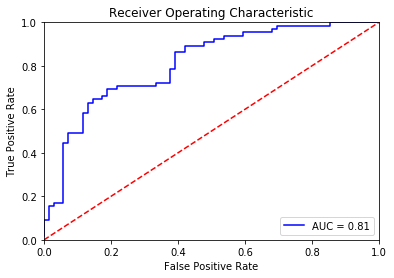

In [29]:
rocCurve(prob_2)

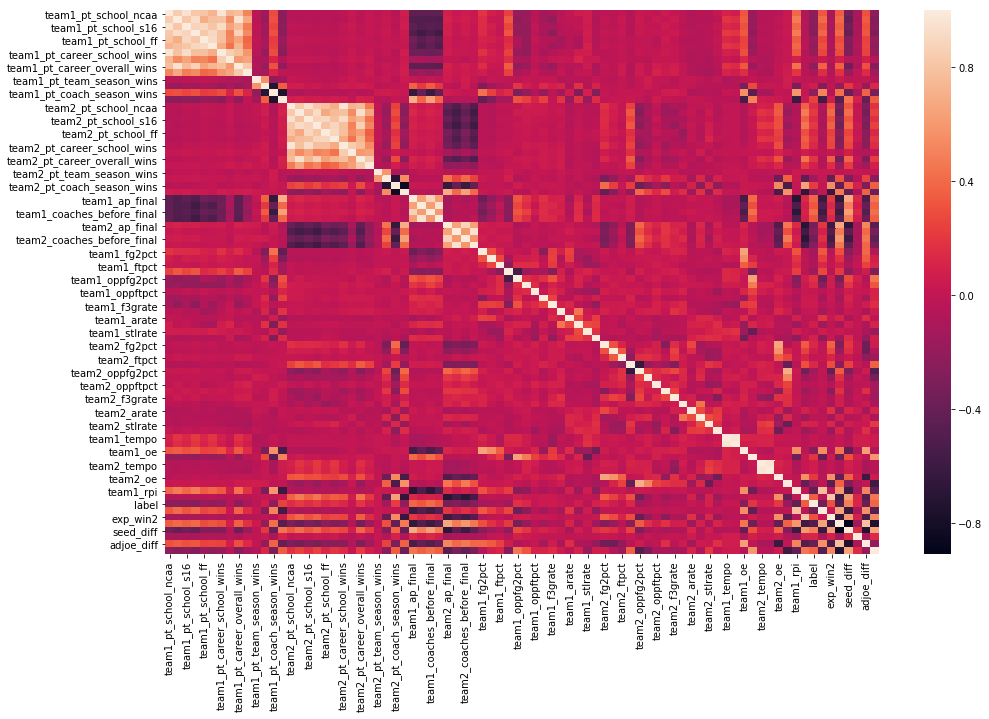

In [30]:
fig, ax = plt.subplots(figsize=(16,10)) 
sns.heatmap(shuffled.corr())

### calculate coach influence
#### coach variables have srtong correlation 教练数据有很强的相关性 对其进行整合，计算教练胜率
#### coach season win% 
#### coach career win% at this school

In [31]:
df2 = shuffled.copy()

In [32]:
df2['team1_seasonwin'] = df2['team1_pt_coach_season_wins']/(df2['team1_pt_coach_season_wins']+df2['team1_pt_coach_season_losses'])
df2['team2_seasonwin'] = df2['team2_pt_coach_season_wins']/(df2['team2_pt_coach_season_wins']+df2['team2_pt_coach_season_losses'])
df2['team1_overallwin'] = df2['team1_pt_career_school_wins']/(df2['team1_pt_career_school_wins']+df2['team1_pt_career_school_losses'])
df2['team2_overallwin'] = df2['team2_pt_career_school_wins']/(df2['team2_pt_career_school_wins']+df2['team2_pt_career_school_losses'])

In [33]:
df2.drop(columns=['team1_pt_coach_season_wins','team2_pt_coach_season_wins','team1_pt_career_school_wins',\
                  'team2_pt_career_school_wins'],inplace=True)

## Feature Selection

In [34]:
scaler = StandardScaler()

In [35]:
gameid = df2['game_id'].values.tolist()
label = df2['label'].values.tolist()

In [36]:
# df3 = pd.DataFrame(data)
df3 = df2.drop(columns = ['game_id','label'])

In [37]:
train_data = df3[:-134]
result = label[:-134]

In [38]:
train_data.shape

(978, 81)

### L1_based selection

In [39]:
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(train_data, result)
model = SelectFromModel(lsvc, prefit=True)
df_lsvc = pd.DataFrame(model.transform(df3))
df_lsvc.shape

(1112, 30)

In [40]:
df_lsvc['game_id'] = gameid
df_lsvc['label'] = label

### Tree_based selection

In [41]:
etc = ExtraTreesClassifier()
etc = etc.fit(train_data, result)
model = SelectFromModel(etc, prefit=True)
df_etc = pd.DataFrame(model.transform(df3))
df_etc.shape

(1112, 20)

In [42]:
df_etc['label'] = label
df_etc['game_id'] = gameid

### Pearson Correlation

In [43]:
categories = []
categories = train_data.columns
data_pearson = train_data
for cat in categories:
    if scipy.stats.pearsonr(train_data[cat], result)[1]>0.05:
        del data_pearson[cat]
    elif scipy.stats.pearsonr(train_data[cat], result)[0]<0.3:
        del data_pearson[cat]
selected = pd.DataFrame(data_pearson)
cols = selected.columns.values.tolist()
cols.append('label')
cols.append('game_id')
df_pearson = df2[cols]

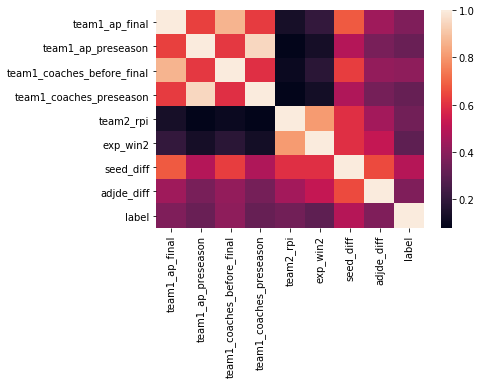

In [44]:
sns.heatmap(df_pearson.corr())

## Model Fit

In [45]:
def evaluate(model, X_train, X_test, y_train, y_test): 
    global prob_1,prob_2
    X_train=scaler.fit_transform(X_train)
    X_test=scaler.fit_transform(X_test)
    model.fit(X_train, y_train)
    prob_1 = model.predict_proba(X_train)
    predict_1 = model.predict(X_train)
    prob_2 = model.predict_proba(X_test)
    predict_2 = model.predict(X_test)
    
    print('Train Resutl:\nLogLoss: %f \nAccuracy: %f\nrecall: %f\nprecision: %f\nf1:%f' % \
          (log_loss(y_train,prob_1),acc(y_train, predict_1),recall(y_train, predict_1),precision(y_train, predict_1),\
          f1(y_train, predict_1)))
    print('\nTest Result:\nLogLoss: %f \nAccuracy: %f\nrecall: %f\nprecision: %f\nf1:%f' % \
          (log_loss(y_test,prob_2),acc(y_test, predict_2),recall(y_test, predict_2),precision(y_test, predict_2),\
          f1(y_test, predict_2))) 

In [46]:
X_train, X_test, y_train, y_test = splitData(df_lsvc)
evaluate(log_clf,X_train, X_test, y_train, y_test)

Train Resutl:
LogLoss: 0.497207 
Accuracy: 0.732106
recall: 0.755601
precision: 0.723197
f1:0.739044

Test Result:
LogLoss: 0.522469 
Accuracy: 0.731343
recall: 0.738462
precision: 0.716418
f1:0.727273


In [47]:
X_train, X_test, y_train, y_test = splitData(df_etc)
evaluate(log_clf,X_train, X_test, y_train, y_test)

Train Resutl:
LogLoss: 0.469031 
Accuracy: 0.780164
recall: 0.778004
precision: 0.782787
f1:0.780388

Test Result:
LogLoss: 0.396084 
Accuracy: 0.835821
recall: 0.861538
precision: 0.811594
f1:0.835821


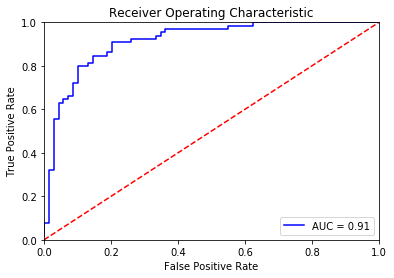

In [48]:
rocCurve(prob_2)

In [49]:
X_train, X_test, y_train, y_test = splitData(df_pearson)
evaluate(log_clf,X_train, X_test, y_train, y_test)

Train Resutl:
LogLoss: 0.529228 
Accuracy: 0.709611
recall: 0.716904
precision: 0.708249
f1:0.712551

Test Result:
LogLoss: 0.513363 
Accuracy: 0.768657
recall: 0.753846
precision: 0.765625
f1:0.759690


In [50]:
svc = SVC(C=5, kernel='rbf', degree=3, gamma='auto', coef0=0.0, shrinking=True, probability=True, tol=0.0001, 
          cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape='ovr', 
          random_state=None)

In [51]:
X_train, X_test, y_train, y_test = splitData(df_etc)
evaluate(svc,X_train, X_test, y_train, y_test)

Train Resutl:
LogLoss: 0.328072 
Accuracy: 0.902863
recall: 0.887984
precision: 0.915966
f1:0.901758

Test Result:
LogLoss: 0.430998 
Accuracy: 0.813433
recall: 0.815385
precision: 0.803030
f1:0.809160


In [52]:
X_train, X_test, y_train, y_test = splitData(df_lsvc)
evaluate(svc,X_train, X_test, y_train, y_test)

Train Resutl:
LogLoss: 0.345614 
Accuracy: 0.935583
recall: 0.940937
precision: 0.931452
f1:0.936170

Test Result:
LogLoss: 0.592146 
Accuracy: 0.649254
recall: 0.615385
precision: 0.645161
f1:0.629921


In [53]:
lg_cv = LogisticRegressionCV()

In [54]:
X_train, X_test, y_train, y_test = splitData(df_etc)
evaluate(lg_cv,X_train, X_test, y_train, y_test)

Train Resutl:
LogLoss: 0.468726 
Accuracy: 0.779141
recall: 0.778004
precision: 0.781186
f1:0.779592

Test Result:
LogLoss: 0.387758 
Accuracy: 0.850746
recall: 0.876923
precision: 0.826087
f1:0.850746


In [55]:
knn = KNeighborsClassifier(n_neighbors = 3)
param_grid = [
    {
        'weights': ['uniform'], 
        'n_neighbors': [i for i in range(1, 11)]
    },
    {
        'weights': ['distance'],
        'n_neighbors': [i for i in range(1, 11)], 
        'p': [i for i in range(1, 6)]
    }
]

In [56]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(knn, param_grid)

### df_etc perform well in all versions of data !!

## Model Ensembel

In [57]:
def ensemble_model(X_train, X_test, y_train, y_test):
    
    global predict, prob
    clf1 = LogisticRegression(random_state=1)
    clf2 = RFC= RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
        max_depth=4, max_features='auto', max_leaf_nodes=None,
        min_impurity_decrease=0,
        min_samples_leaf=5, min_samples_split=2,
        min_weight_fraction_leaf=0.0, n_estimators=3000, n_jobs=-1,
        oob_score=True, random_state=0, verbose=0, warm_start=False)
    clf3 = svc = SVC(C=5, kernel='rbf', degree=3, gamma='auto', coef0=0.0, shrinking=True, probability=True, tol=0.0001, 
          cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape='ovr', 
          random_state=None)
    
    eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='soft')
    params = {'rf__max_depth': [3, 5]}
    grid = GridSearchCV(estimator=eclf, param_grid=params, cv=5)
    
    grid = grid.fit(X_train,y_train)
    predict = grid.predict(X_test)
    prob = grid.predict_proba(X_test)
    print('LogLoss: %f \nAccuracy: %f\nrecall: %f\nprecision: %f\nf1:%f'%(log_loss(y_test,prob),\
                                                                          metrics.accuracy_score(y_test, predict),\
                                                                          metrics.recall_score(y_test, predict),\
                                                                          metrics.precision_score(y_test, predict),\
                                                                          metrics.f1_score(y_test, predict)))

In [58]:
# X_train, X_test, y_train, y_test = splitData(df_etc)
# ensemble_model(X_train, X_test, y_train, y_test)

## Result

#### Reduce Variable Numbers from 102 to 20
#### Reduce Logloss from 0.58 to 0.39
#### Improve accuracy from 0.72 to 0.83
#### Improve recall from 0.66 to 0.86
#### Improve precision from 0.74 to 0.81